In [1]:
using Plots
using Statistics
using CSV
using DataFrames

In [2]:
"""
    ising_metropolis_sweep(spins, T, E, M)

Perform one sweep of the lattice using single-spin-flip dynamics (1 sweep == N*N flip attempts).
Here arguments E and M are the total energy and total magnetization before the sweep.
Returns total energy and magnetization after sweep.
"""
function ising_metropolis_sweep!(spins, T, E, M)
    N = size(spins)[1]
    for i=1:N^2
        k = rand(1:N, 2)
        ΔE = deltaE(spins, k, N)
        if accept_flip(ΔE, T)
            spins[k[1], k[2]] *= -1
            E = E + ΔE
            M = M + 2spins[k[1], k[2]]
        end
    end
    return E, M
end

ising_metropolis_sweep!

In [3]:
"""
    accept_flip(spins, N, k_i, k_j, T)

Determine whether to accept the next state or not according to Metropolis acceptance rates.
Returns `true` or `false`.
"""
function accept_flip(ΔE, T)
    # Metropolis Acceptance Rates
    if ΔE <= 0
        return true
    elseif rand() < exp(-ΔE/T)
        return true
    else
        return false
    end
end

accept_flip

In [4]:
"""
    delta_E(spins, k)

Calculate the energy difference between two states for one spin flip at site k.
"""
function deltaE(spins, k, N)
    ΔE = 0
    for δ ∈ ([1, 0], [N-1, 0], [0, 1], [0, N-1])
        nn = k + δ
        @. nn = mod1(nn, N)  # Apply periodic boundary conditions
        ΔE += spins[nn[1], nn[2]]
    end
    ΔE *= 2spins[k[1], k[2]]
end

deltaE

In [5]:
"""
    total_magnetization(spins)

Calculate the total magnetization of square spin lattice.
"""
function total_magnetization(spins)
    return sum(sum(spins))
end

total_magnetization

In [6]:
"""
    total_energy(spins)

Calculate the total energy of the square spin lattice (with zero field and J=1).
"""
function total_energy(spins)
    N = size(spins)[1]
    running_sum = 0
    for i=1:N
        for j=1:N
            s_k = spins[i, j]
            for δ ∈ ([1, 0], [N-1, 0], [0, 1], [0, N-1])
                nn = [i, j] + δ
                @. nn = mod1(nn, N)  # Apply periodic boundary conditions
                running_sum += s_k*spins[nn[1], nn[2]]
            end
        end
    end
    return -running_sum / 2  # divide by 2 because each bond counted twice
end

total_energy

In [7]:
"""
    autocorrelation_fn(mags, N)

Calculate the autocorrelation function (normalized) of the given time series array.
"""
function autocorrelation_fn(series, N)
    tmax = length(series)
    autocorr = zeros(Float64, tmax)
    for t ∈ 1:tmax-1
        sum1 = 0
        sum2 = 0
        sum3 = 0
        for tk ∈ 1:tmax-t
            sum1 += series[tk]*series[tk+t]
            sum2 += series[tk]
            sum3 += series[tk+t]
        end
        autocorr[t] = sum1 / (tmax-t) - (sum2*sum3) / (tmax - t)^2
    end
    @. autocorr /= N^2
    @. autocorr /= autocorr[1]
    return autocorr
end

autocorrelation_fn

In [8]:
"""
    bootstrap_err(samples, calc_qty; r=100)

Estimate the error in the given samples by bootstrap method. `calc_qty` is the function to calculate the quantity in which error has to be calculated. `r` is a keyword arguments giving number of resamples.
"""
function bootstrap_err(samples, calc_qty, args...; r=100)
    nob = length(samples)
    resample_arr = zeros(Float64, nob)
    for i=1:r
        resample = rand(samples, nob)
        resample_arr[i] = calc_qty(resample, args...)
    end
    err = std(resample_arr, corrected=false)
    return err
end

bootstrap_err

In [9]:
"""
    specific_heat(u_vals, T, N)

Calculate the specific heat from given array of internal energy per site (`N²` sites) at temperature `T`.
"""
function specific_heat(u_vals, T, N)
    return (T^-2) * N^2 * var(u_vals, corrected=false)
end

specific_heat

In [10]:
"""
    succeptibility(m_vals, T, N)

Calculate the succeptibility from given array of mean magnetization per site (`N²` sites) at temperature `T`.
"""
function succeptibility(m_vals, T, N)
    return (T^-2) * N^2 * var(m_vals, corrected=false)
end

succeptibility

In [13]:
N = 20  # Lattice size
# spins = ones(N, N)  # T = 0
spins = rand([-1, 1], (N, N))  # T = ∞
# T = 2.2
eqsteps = 2000  # Number of steps for equilibration
nsteps = 6000  # Number of steps for measurements
# heatmap(spins, color=:winter)

Temps = collect(1.4:0.2:3.4)
autocorr_time = zeros(Float64, length(Temps))
for stepT in 1:length(Temps)
    T = Temps[stepT]
    # Equilibration
    E0, M0 = total_energy(spins), total_magnetization(spins)
    for i in 1:eqsteps
        E0, M0 = ising_metropolis_sweep!(spins, T, E0, M0)
    end
    
    mags = zeros(Float64, nsteps)
    mags[1] = M0

    for i in 1:nsteps-1
        E0, mags[i+1] = ising_metropolis_sweep!(spins, T, E0, mags[i])
    end
    
    @. mags /= N^2
    autocorr = autocorrelation_fn(mags, N)
    autocorr_time[stepT] = sum(autocorr[1:100]) 
end

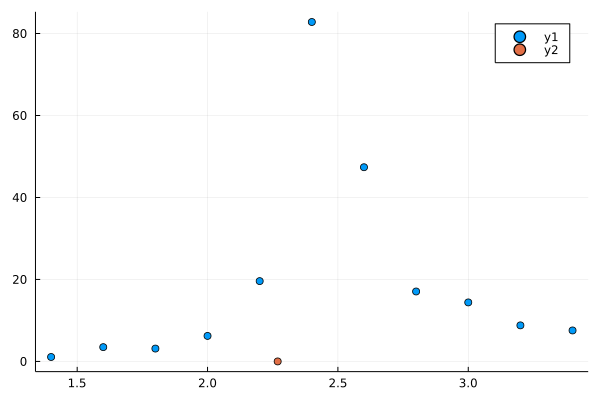

In [14]:
scatter(Temps, autocorr_time)
scatter!([2.269], [0])

# Making Uncorrelated Measurements

In [94]:
N = 10  # Lattice size
Nr = 50  # Number of uncorrelated measurements
spins = ones(N, N)  # T = 0
uncorrelated_spins = zeros(N, N, Nr);

eqsteps = 2000
uncorr_measurement_times = 2 .* ceil.(autocorr_time)
@. nsteps_uncorr = convert(Int64, Nr*uncorr_measurement_times)

11-element Vector{Int64}:
  200
  400
  400
  700
 2000
 8300
 4800
 1800
 1500
  900
  800

In [99]:
for stepT in 1:1 #length(Temps)
    T = 2.0
    # equilibration
    E0, M0 = total_energy(spins), total_magnetization(spins)
    for i in 1:eqsteps
        E0, M0 = ising_metropolis_sweep!(spins, T, E0, M0)
    end

    # uncorrelated measurements
    for j in 1:200
        E0, M0 = ising_metropolis_sweep!(spins, T, E0, M0)
        if j%4 == 0
            uncorrelated_spins[:, :, j÷4] = spins
        end
    end
end

In [100]:
uncorrelated_spins

10×10×50 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0